In [120]:
import pandas as pd
import cptac
import numpy as np
import requests
import json
import deva
import binarization_functions_1 as bf
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.nonparametric import kaplan_meier_estimator
import scipy

In [5]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()

In [85]:
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

In [7]:
#We are only looking at the discovery cohort, so we will separate the data into two tables based on cohort
cohort_filter = follow_up['Cohort'] == "Disc"
discovery_cohort = follow_up[cohort_filter]
other_cohort = follow_up[~cohort_filter]

In [8]:
cols_to_drop = ['Tumor code', 'ECOG Score', 
                'Karnofsky Score', 'Perform Status Scale: Timing', 
                'Other Perform Scale Timing', 
                'Specify Other New Tumor Site', 'Tamoxifen']

discovery_cohort = discovery_cohort.drop(cols_to_drop, axis=1)

for col in discovery_cohort.columns:
    if len(discovery_cohort[col].value_counts()) <= 1:
        discovery_cohort = discovery_cohort.drop(col, axis=1)
        
things_to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown', 
                     'Not Applicable', 'na', 'unknown', 'Not Performed', 
                     'Unknown tumor status', 'Unknown', 
                     'Unknown Tumor Status', 'Not specified']

for col in discovery_cohort.columns:
    discovery_cohort[col] = discovery_cohort[col].replace(things_to_replace, np.nan)

In [9]:
discovery_cohort = discovery_cohort.rename({'Case ID': 'Patient_ID'}, axis='columns')

In [10]:
patient_data = pd.merge(clinical, discovery_cohort, on = 'Patient_ID')

In [11]:
patient_data

,Patient_ID,Proteomics_Tumor_Normal,Country,Histologic_Grade_FIGO,Myometrial_invasion_Specify,Histologic_type,Treatment_naive,Tumor_purity,Path_Stage_Primary_Tumor-pT,Path_Stage_Reg_Lymph_Nodes-pN,...,Success of Initial Treatment,Success of Treatment@ Followup,New Tumor After Initial TRT,Path Diag to new Tumor (days),Additional Surgery ?,Path Diag to Surgery (days),Residual Tumor After Surgery,Radiation for New Tumor,Pharmaceutical for New Tumor,Immunological for New Tumor
0,C3L-00006,Tumor,United States,FIGO grade 1,under 50 %,Endometrioid,YES,Normal,pT1a (FIGO IA),pN0,...,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C3L-00006,Tumor,United States,FIGO grade 1,under 50 %,Endometrioid,YES,Normal,pT1a (FIGO IA),pN0,...,NaN,Complete Remission,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C3L-00006,Tumor,United States,FIGO grade 1,under 50 %,Endometrioid,YES,Normal,pT1a (FIGO IA),pN0,...,NaN,Complete Remission,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C3L-00006,Adjacent_normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C3L-00006,Adjacent_normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Complete Remission,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,C3N-01537,Tumor,Ukraine,FIGO grade 2,50 % or more,Endometrioid,YES,Normal,pT2 (FIGO II),pN0,...,Complete Remission,Complete Remission,Yes,57.0,Yes,61.0,RX,No,Yes,No
256,C3N-01802,Tumor,United States,NaN,under 50 %,Serous,YES,Normal,pT2 (FIGO II),pN0,...,Complete Remission,Complete Remission,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,C3N-01802,Tumor,United States,NaN,under 50 %,Serous,YES,Normal,pT2 (FIGO II),pN0,...,Complete Remission,Persistent Disease,Yes,597.0,No,NaN,NaN,No,No,No
258,C3N-01825,Tumor,Ukraine,NaN,under 50 %,Serous,YES,Normal,pT1a (FIGO IA),pN0,...,Complete Remission,Complete Remission,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
columns_to_focus_on = ['Patient_ID', 'Lost to Follow-up?', 'Vital Status', 
                       'Histologic_Grade_FIGO', 'Path Diag to Last Contact(Day)', 
                       'Cause of Death', 'Success of Initial Treatment',
                       'Path Diag to Death(days)', 'Follow-up Period',
                       'Success of Treatment@ Followup', 'Histologic_type', 
                       'New Tumor After Initial TRT',
                       'Path Diag to new Tumor (days)', 'BMI']

In [13]:
focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()
focus_group_subset = focus_group[['Vital Status', 
                                  'Path Diag to Last Contact(Day)', 
                                  'Histologic_type']]
focus_group_subset = focus_group_subset.replace('Living', False)
focus_group_subset = focus_group_subset.replace('Deceased', True)
focus_group_subset = focus_group_subset.dropna()

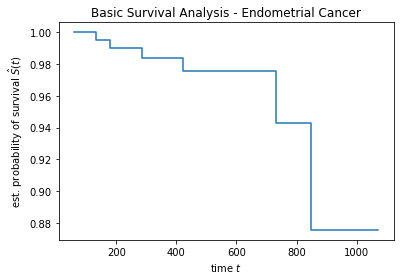

In [14]:
time, survival_prob = kaplan_meier_estimator(focus_group_subset["Vital Status"], 
                                             focus_group_subset["Path Diag to Last Contact(Day)"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Basic Survival Analysis - Endometrial Cancer")
plt.show()

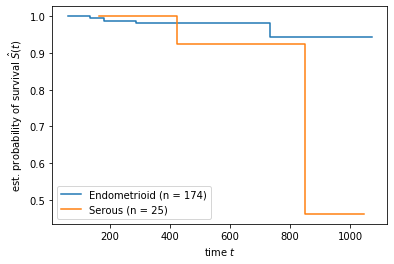

In [15]:
for value in focus_group_subset["Histologic_type"].unique():
    mask = focus_group_subset["Histologic_type"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(focus_group_subset["Vital Status"][mask],
                                                           focus_group_subset["Path Diag to Last Contact(Day)"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")
plt.show()

In [16]:
#Look at P53 mutations
#get_somatic_mutations, then slice out for P53, and then group_by ID
#Join mutation data with the clinical dataframe and follow_up data
#Add the p-values and the cox proportional hazard values
#Actual death-dates??
mutations = en.get_somatic_mutation()

In [17]:
tp53_filter = mutations['Gene'] == 'TP53'
tp53_mutations = mutations[tp53_filter]

In [18]:
omics_mutations = en.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes='TP53', 
                                             omics_genes='TP53', mutations_filter=[])

In [19]:
omics_mut_clin = pd.merge(omics_mutations, clinical, on='Sample_ID')

In [20]:
omics_mut_clin_fol = pd.merge(discovery_cohort, omics_mut_clin, on='Patient_ID')

In [21]:
cols_to_focus_on = ['Vital Status', 'Path Diag to Last Contact(Day)', 
                    'Path Diag to Death(days)', 'TP53_proteomics', 
                    'TP53_Mutation', 'TP53_Location', 'TP53_Mutation_Status']

cols_to_focus_on2 = ['Vital Status', 'Path Diag to Last Contact(Day)', 
                    'TP53_proteomics','TP53_Mutation', 'TP53_Location', 
                     'TP53_Mutation_Status', 'BMI']

mutation_test = omics_mut_clin_fol[cols_to_focus_on2].copy().drop_duplicates()

In [22]:
mutation_test = mutation_test.dropna()

In [23]:
mutation_test = mutation_test.replace("Living", False)
mutation_test = mutation_test.replace("Deceased", True)

In [24]:
mutation_data = mutation_test.drop(['Vital Status', 'TP53_proteomics',
                                    'Path Diag to Last Contact(Day)'],
                                   axis = 1).copy()

survival_data = mutation_test[['Vital Status', 'Path Diag to Last Contact(Day)']].copy()

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


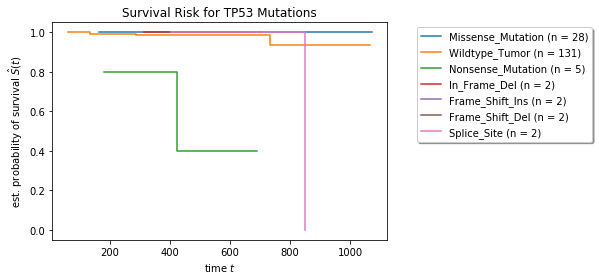

In [25]:
for value in mutation_test["TP53_Mutation"].unique():
    mask = mutation_test["TP53_Mutation"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(mutation_test["Vital Status"][mask],
                                                           mutation_test["Path Diag to Last Contact(Day)"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1), shadow=True, ncol=1)
plt.title('Survival Risk for TP53 Mutations')
plt.show()

In [26]:
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [27]:
test = np.zeros(len(survival_data), 
                dtype={'names':('Vital Status', 
                                'Path Diag to Last Contact(Day)'), 
                       'formats':('?', '<f8')})
print(test.dtype)

[('Vital Status', '?'), ('Path Diag to Last Contact(Day)', '<f8')]


In [28]:
test['Vital Status'] = survival_data['Vital Status'].values
test['Path Diag to Last Contact(Day)'] = survival_data['Path Diag to Last Contact(Day)'].values

In [29]:
mutation_data.head()

,TP53_Mutation,TP53_Location,TP53_Mutation_Status,BMI
0,Missense_Mutation,p.R248W,Single_mutation,38.88
2,Missense_Mutation,p.R248W,Single_mutation,38.88
4,Missense_Mutation,p.R248W,Single_mutation,38.88
6,Wildtype_Tumor,No_mutation,Wildtype_Tumor,39.76
7,Wildtype_Tumor,No_mutation,Wildtype_Tumor,39.76


In [30]:
for col in mutation_data.columns:
    if col == 'BMI':
        continue
    mutation_data[col] = mutation_data[col].astype('category')

for col in mutation_data.columns:
    print(col)
    print(mutation_data[col].dtype)

TP53_Mutation
category
TP53_Location
category
TP53_Mutation_Status
category
BMI
float64


In [31]:
mutations_numeric = OneHotEncoder().fit_transform(mutation_data)

In [33]:
test_list = ['TP53_Mutation=Frame_Shift_Ins', 'TP53_Mutation=In_Frame_Del',
       'TP53_Mutation=Missense_Mutation', 'TP53_Mutation=Nonsense_Mutation',
       'TP53_Mutation=Splice_Site', 'TP53_Mutation=Wildtype_Tumor',
       'TP53_Location=p.A159P', 'TP53_Location=p.E198*',
       'TP53_Location=p.E343Gfs*2', 'TP53_Location=p.G244D',
       'TP53_Location=p.H193L', 'TP53_Location=p.K164E',
       'TP53_Location=p.L14P', 'TP53_Location=p.P27S', 'TP53_Location=p.R175H',
       'TP53_Location=p.R196*', 'BMI','TP53_Location=p.R213*',
       'TP53_Location=p.R248W', 'TP53_Location=p.R249S',
       'TP53_Location=p.R273H', 'TP53_Location=p.S127Y',
       'TP53_Location=p.S241C', 'TP53_Location=p.S241del',
       'TP53_Location=p.V217Wfs*31', 'TP53_Location=p.X225_splice',
       'TP53_Mutation_Status=Single_mutation',
       'TP53_Mutation_Status=Wildtype_Tumor']

In [34]:
mutations_numeric = mutations_numeric.dropna()

In [37]:
##Not sure how to deal with the NaN/Infinity stuff since I already dropped nans...
#estimator = CoxPHSurvivalAnalysis()
#estimator.fit(mutations_numeric[test_list], test)

## Starting the Kaplan Meier stuff for the genes Sam wanted me to study

In [111]:
omics_genes = ['GBP2', 'GBP5', 'RAC2']

In [112]:
df = en.join_metadata_to_omics(metadata_df_name = 'clinical', 
                               omics_df_name = "proteomics", 
                               metadata_cols = "Patient_ID", 
                               omics_genes = omics_genes)

In [113]:
df_genes = df.merge(follow_up,
                    left_on = "Patient_ID",
                    right_on = "Case ID")

In [114]:
focus_genes = df_genes[['Vital Status',
                        'Path Diag to Last Contact(Day)', 
                        'GBP2_proteomics', 'GBP5_proteomics', 
                        'RAC2_proteomics']].copy()

In [125]:
focus_genes_clean = focus_genes.copy()
omics_cols = ['GBP2_proteomics', 'GBP5_proteomics', 'RAC2_proteomics']

for col in omics_cols:
    lower_25_filter = focus_genes_clean[col] <= focus_genes_clean[col].quantile(.25)
    upper_25_filter = focus_genes_clean[col] >= focus_genes_clean[col].quantile(.75)

    focus_genes_clean[col] = np.where(lower_25_filter, "Lower_25%", 
                                      focus_genes_clean[col])
    focus_genes_clean[col] = np.where(upper_25_filter, "Upper_25%", 
                                      focus_genes_clean[col])
    focus_genes_clean[col] = np.where(~lower_25_filter & ~upper_25_filter, 
                                      "Middle_50%", focus_genes_clean[col])
    
focus_genes_clean['Vital Status'] = focus_genes_clean['Vital Status'].replace('Living', False)
focus_genes_clean['Vital Status'] = focus_genes_clean['Vital Status'].replace('Deceased', True)

In [126]:
focus_genes_clean

,Vital Status,Path Diag to Last Contact(Day),GBP2_proteomics,GBP5_proteomics,RAC2_proteomics
0,False,494.0,Lower_25%,Upper_25%,Middle_50%
1,False,717.0,Lower_25%,Upper_25%,Middle_50%
2,False,737.0,Lower_25%,Upper_25%,Middle_50%
3,False,494.0,Upper_25%,Middle_50%,Middle_50%
4,False,717.0,Upper_25%,Middle_50%,Middle_50%
...,...,...,...,...,...
255,False,698.0,Upper_25%,Upper_25%,Upper_25%
256,False,401.0,Upper_25%,Upper_25%,Middle_50%
257,False,774.0,Upper_25%,Upper_25%,Middle_50%
258,False,199.0,Middle_50%,Middle_50%,Upper_25%


In [122]:
#T-tests to compare gene expression levels between living and deceased
#df_clean = df_genes.dropna(axis=0, how='any')
living = df_genes[df_genes["Vital Status"] == 'Living']
dead = df_genes[df_genes["Vital Status"] == 'Deceased']
#living
for gene in omics_genes:
    print(gene)
    gene += "_proteomics"
    print(scipy.stats.ttest_ind(living[gene], dead[gene]), '\n')

GBP2
Ttest_indResult(statistic=-0.7342137813069052, pvalue=0.4634851888023338) 

GBP5
Ttest_indResult(statistic=1.3397755485601481, pvalue=0.1814971903531838) 

RAC2
Ttest_indResult(statistic=-0.09308078909211497, pvalue=0.9259116184422335) 



In [ ]:
#Make a Kaplan Meier Plot here.  Look at the Ovarian code